# Демонстрация: Промышленный пайплайн обработки больших данных

**Задача:** ETL PubChem (8+ ГБ)в современный, сжатый и высокопроизводительный формат Parquet, готовый для задач машинного обучения.

1.  **Настройка среды:** Установка необходимых серверных утилит и Python-библиотек.
2.  **Конфигурация:** Определение всех путей и констант.
3.  **Извлечение (Extract):** Быстрое и надежное скачивание исходных данных с помощью `aria2c`.
4.  **Преобразование (Transform) и Загрузка (Load):** Эффективная обработка 8 ГБ файла без переполнения памяти с помощью `Dask` и его сохранение в форматы Parquet и CSV для сравнения.
5.  **Анализ и Визуализация:** Наглядное сравнение форматов по занимаемому месту на диске и производительности.

## 1. Настройка среды

In [ ]:
# !poetry add pandas pyarrow datasets requests notebook tqdm psutil matplotlib seaborn "dask[dataframe]"

In [ ]:
# !sudo apt-get update && sudo apt-get install -y aria2

In [1]:
from pathlib import Path
import dask.dataframe as dd
import dask
import time
import pandas as pd
import psutil
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Конфигурация проекта

Определяем все пути в одном месте. Это лучшая практика для обеспечения чистоты и воспроизводимости кода.

In [2]:
# --- Конфигурация путей ---
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# --- Конфигурация источника данных ---
DATA_URL = "ftp://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-SMILES.gz"
ARCHIVE_FILE = DATA_DIR / os.path.basename(DATA_URL)
UNPACKED_FILE = DATA_DIR / ARCHIVE_FILE.name.removesuffix('.gz') 

# --- Конфигурация выходных данных ---
CSV_PATH = DATA_DIR / "pubchem_full.csv" 
PARQUET_DIR = DATA_DIR / "pubchem_compounds.parquet.dask" 

print("config:")
print(f"  Директория данных: {DATA_DIR.resolve()}")
print(f"  Исходный архив: {ARCHIVE_FILE.name}")
print(f"  Распакованный файл: {UNPACKED_FILE.name}")
print(f"  Итоговый CSV: {CSV_PATH.name}")
print(f"  Итоговый Parquet: {PARQUET_DIR.name}")

config:
  Директория данных: /app/data
  Исходный архив: CID-SMILES.gz
  Распакованный файл: CID-SMILES
  Итоговый CSV: pubchem_full.csv
  Итоговый Parquet: pubchem_compounds.parquet.dask


## 3. Extract: `aria2c` + `gunzip`

In [3]:
# --- Шаг 1: Скачивание с помощью aria2c ---
command_aria = f'aria2c -c -x 8 -s 8 --dir="{DATA_DIR}" "{DATA_URL}"'
print(f"downloading: {command_aria}\n")
!{command_aria}

# --- Шаг 2: Распаковка с помощью gunzip ---
command_gunzip = f'gunzip -k "{ARCHIVE_FILE}"'
print(f"\nunpack: {command_gunzip}")
if os.path.exists(ARCHIVE_FILE) and not os.path.exists(UNPACKED_FILE):
    !{command_gunzip}
    print("unpacked")
else:
    print("unpacked file exists")

downloading: aria2c -c -x 8 -s 8 --dir="../data" "ftp://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-SMILES.gz"


07/09 12:14:14 [NOTICE] Downloading 1 item(s)
[#90067b 1.3GiB/1.3GiB(99%) CN:1 DL:53KiB]
07/09 12:14:27 [NOTICE] Download complete: ../data/CID-SMILES.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
90067b|OK  |   4.9KiB/s|../data/CID-SMILES.gz

Status Legend:
(OK):download completed.

unpack: gunzip -k "../data/CID-SMILES.gz"
unpacked file exists


## 4. Transform & Load

`Dask` lazy multicpu read

In [4]:
# --- Создание Dask DataFrame ---
ddf = dd.read_csv(
    UNPACKED_FILE, 
    sep='\t', 
    header=None,                  
    names=['cid', 'smiles'],      
    dtype={'cid': 'str', 'smiles': 'str'}, 
    blocksize='64MB'
)
display(ddf.head())

# --- Сохранение в Parquet (быстрый шаг) ---
print(f"\nсохранение в Parquet в директорию {PARQUET_DIR.name}...")
start_time_parquet = time.time()
ddf.to_parquet(PARQUET_DIR, engine='pyarrow', compression='snappy', write_index=False, compute=True, overwrite=True)
total_time_parquet = time.time() - start_time_parquet
print(f"Сохранение в Parquet завершено за {total_time_parquet:.2f} сек.")

# # --- Сохранение в ЕДИНЫЙ CSV ФАЙЛ (медленный шаг) ---
# print(f"\nсоздание полного CSV файла ({CSV_PATH.name}).")
# start_time_csv = time.time()
# computation_csv = ddf.to_csv(str(CSV_PATH), single_file=True, index=False, compute=False)
# dask.compute(computation_csv)
# total_time_csv = time.time() - start_time_csv
# print(f"Полный CSV файл создан за {total_time_csv:.2f} сек.")

,cid,smiles
0,1,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
1,2,CC(=O)OC(CC(=O)O)C[N+](C)(C)C
2,3,C1=CC(C(C(=C1)C(=O)O)O)O
3,4,CC(CN)O
4,5,C(C(=O)COP(=O)(O)O)N



сохранение в Parquet в директорию pubchem_compounds.parquet.dask...
Сохранение в Parquet завершено за 161.65 сек.


## 5. Анализ и Визуализация №1: Размер на диске

размер CSV принимается за 100%.

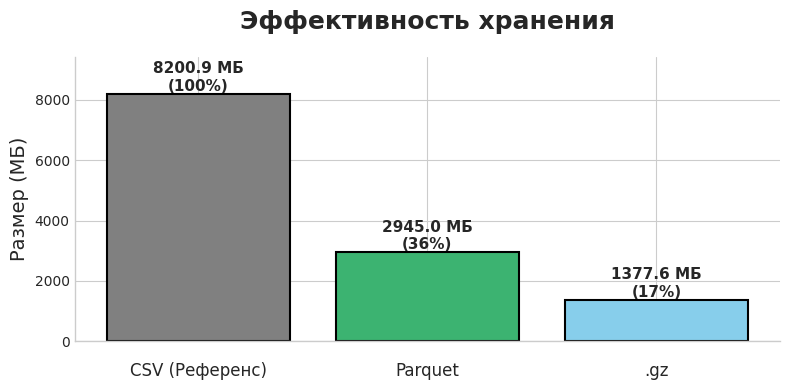

In [4]:
def get_dir_size_mb(path):
    try:
        total = sum(f.stat().st_size for f in Path(path).glob('**/*') if f.is_file())
        return total / (1024 * 1024)
    except FileNotFoundError: return 0

def get_file_size_mb(path):
    try:
        return path.stat().st_size / (1024 * 1024)
    except FileNotFoundError: return 0

packed_size = get_file_size_mb(ARCHIVE_FILE)
unpacked = get_file_size_mb(UNPACKED_FILE)
parquet_total_size = get_dir_size_mb(PARQUET_DIR)

reference_size = unpacked
labels = ['CSV (Референс)', 'Parquet', '.gz']
values = [unpacked, parquet_total_size, packed_size]
percentages = [(v / reference_size) * 100 for v in values]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 4))
colors = ['grey', 'mediumseagreen', 'skyblue']
bars = ax.bar(labels, values, color=colors, edgecolor='black', linewidth=1.5)

for i, bar in enumerate(bars):
    height = bar.get_height()
    label_text = f'{values[i]:.1f} МБ\n({percentages[i]:.0f}%)'
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, label_text, ha='center', va='bottom', fontsize=11, weight='bold')

ax.set_title('Эффективность хранения', fontsize=18, weight='bold', pad=20)
ax.set_ylabel('Размер (МБ)', fontsize=14)
ax.tick_params(axis='x', which='major', pad=15, labelsize=12)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values) * 1.15)
plt.tight_layout()
plt.show()

## 6. Анализ и Визуализация №2: Производительность и Память

`Parquet` vs `CSV`

## 7. Финальные выводы
